In [16]:
# #defining loss tensor for filter visualisation :- 
# #it will be defined as the mean value of the all the response image of the filter we are considering
# #then this loss function is maximised wrt the input image . The image resulting from the values generated by maximising this loss function 
# #corresponds to the one which the chosen filter is maximally responsive to
# #in short the o/p of a filetr will be maximum if the i/P image corresponds to what the filter is looking for(responsive to)
# from keras.applications import VGG16
# from keras import backend as K

# model = VGG16(weights='imagenet',                          #weights of imagenet dataset
#               include_top=False)                           #excluding top(=>dense)layers

# layer_name = 'block3_conv1'
# filter_index = 0

# layer_output = model.get_layer(layer_name).output
# loss = K.mean(layer_output[:, :, :, filter_index])         #defining the loss function for response of 1st filter in block3_conv1 considering all samples(first index [':']indicate this)

# #finding gradient of the loss wrt input
# grads = K.gradients(loss, model.input)[0]                  #using gradient function in backend module of keras it returns a list of tensors here we have a single tensor which max the loss fn. hence we access the first tensor inthe o/p list.

# #normalising the gradient by dividing the result with L2norm(rms). add 1e^-5 to prevent accidental division by zero
# grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)          #this ensures the magnitude of update on the i/p image is always in the same range

# #using function of backend module to give us tensors of the gradient values and the corresponding loss values when we give input image
# #equation for calculating loss and grad is already defined now we used a function to give i/p image to the model and generate loss and and grads as o/p
# iterate = K.function([model.input], [loss, grads])        

# import numpy as np
# loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# #maximising the loss using stochasting gradient ascent
# input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.   #gives a random image input 

# step = 1.                                                         #specifies learning rate

# for i in range(40):                                               #iterates 40 times
#     loss_value, grads_value = iterate([input_img_data])
#     input_img_data += grads_value * step                          #updates the pixel values of the image ussing the grad values generated by iterate function

#post processing the resulting tensor : the image values may not be in range (1,255)
#so defining a function to convert it into a displayable format
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)                                          #vlaues<0 will be set to zero and values>0 will be set to one
    x *= 255
    x = np.clip(x, 0, 255).astype('int32')                        #converts into an rgb array
    return x



In [17]:
#deines a single function which has
#i/p : layer name, filter index
#o/p : image values which maximises the activation of the filer(this represent what the filter is responsive to)
from keras.applications import VGG16
from keras import backend as K
import numpy as np

model = VGG16(weights='imagenet',                          #weights of imagenet dataset
              include_top=False) 


def generate_pattern(layer_name, filter_index, size):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
   
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.

    for i in range(1):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)
    


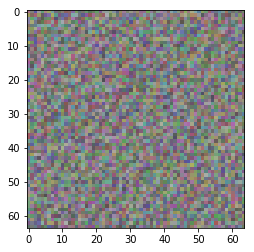

In [18]:
#plotting the convnet filter 
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block1_conv1', 0, 64))

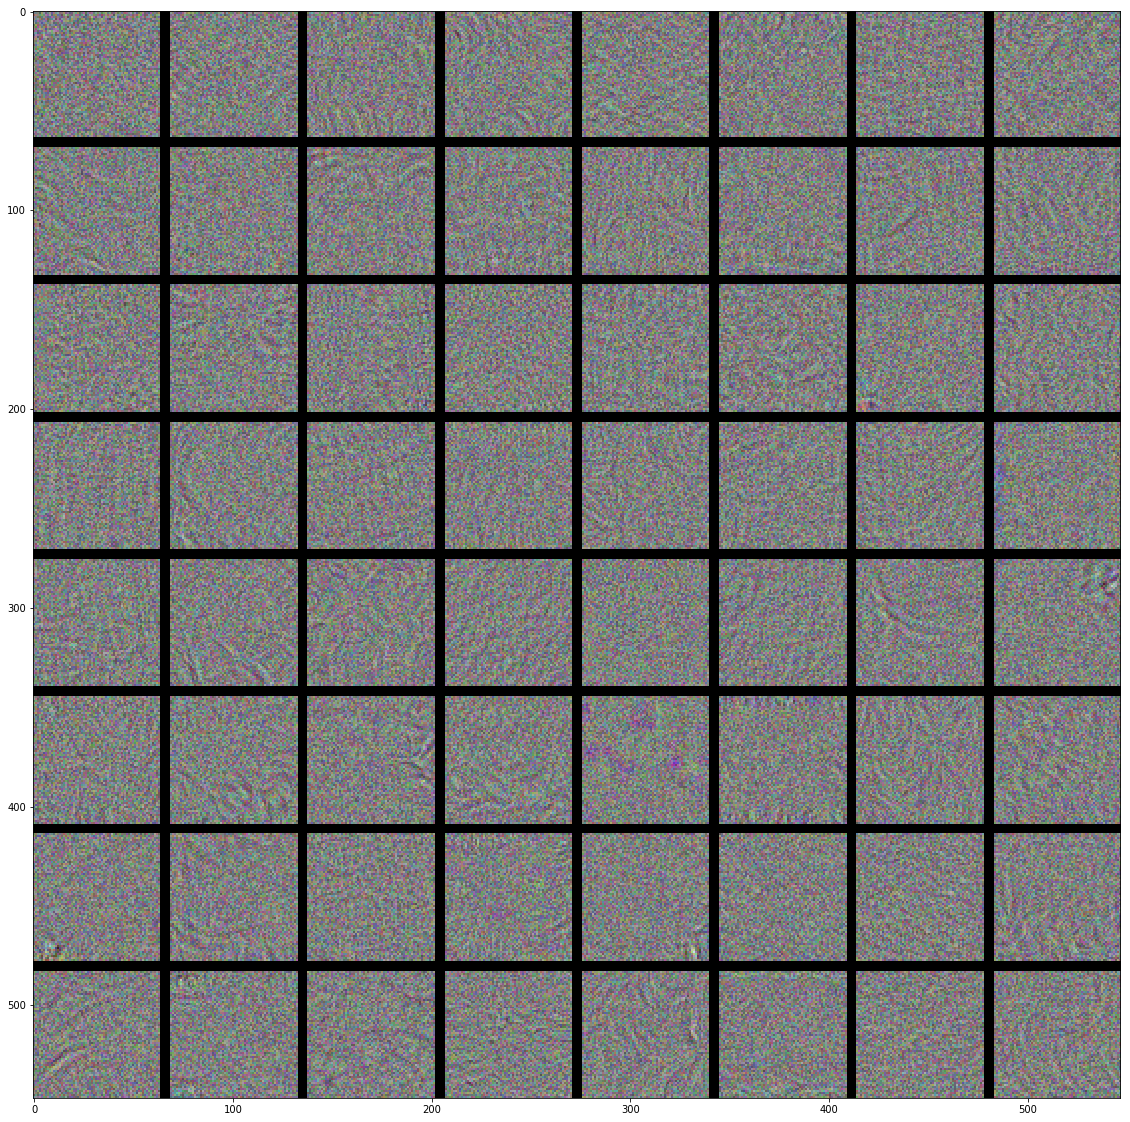

In [19]:
#generating grid of first 64 filter patterns in a layer
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3)).astype(np.int32)      #initialising empty matrix to plot the images into

for i in range(8):                                                         #iterate over the rows of results grid
    for j in range(8):                                                     #iterate over the columns of results grid
        filter_img = generate_pattern(layer_name, i + (j * 8), size)       #generates filter pattern for the first 64 filters(0 to 63) in the specified layer and the resulting image will be of size =64x64
        
        horizontal_start = i * size + i * margin                           #fixes the row first 0:64
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin                             #icreases column values by 0:64 then 64+5:64+5+64 and so on unill the 8th image is placed
        vertical_end = vertical_start + size                               #then same process repeat for row value 64+5:64+5+64
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img              #positions each 64x64 image being generated from the genpattern inside the empty matrix

plt.figure(figsize=(20, 20))

plt.imshow(results)



In [20]:
results.dtype

dtype('int32')